In [67]:
import biom
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Microbiome

In [68]:
instruments = pd.read_table('../data/instrument.txt', index_col=0)
phenotype = pd.read_table('../data/phenotype.txt', index_col=0)

In [69]:
table = biom.load_table('../data/hcc-data/46119_otu_table.biom').to_dataframe().T

confounder = pd.read_csv('../data/cleaned-data/microbiome_confounder.csv', index_col=0)
family = pd.read_csv('../data/cleaned-data/microbiome_family.csv', index_col=0)
instrument = pd.read_csv('../data/cleaned-data/microbiome_instrume.csv', index_col=0)
outcome = pd.read_csv('../data/cleaned-data/microbiome_outcome.csv', index_col=0)

outcome.index = family.index # fingers crossed!
instrument.index = family.index 
confounder.index = family.index 
table = table.loc[family.index]

# read in loadings from IV analysis
microbeV = pd.read_excel('../application/HCC/microbiome_analysis.xlsx', 
                         sheet_name='Figure V', index_col=0)
microbeV.index = list(map(str, microbeV.index))

Compute balances from ranks

In [70]:
microbe_ranks = microbeV['V1'].sort_values()
denom = microbe_ranks.loc[microbe_ranks < 0].index
num = microbe_ranks.loc[microbe_ranks > 0].index

balance = pd.DataFrame({
    'balance' : np.log(table[num] + 1).mean(axis=1) - np.log(table[denom] + 1).mean(axis=1)
})

microbe_md = pd.merge(outcome, balance, left_index=True, right_index=True)
microbe_md = pd.merge(microbe_md, confounder, left_index=True, right_index=True)
microbe_md = pd.merge(microbe_md, instruments, left_index=True, right_index=True)

Text(0.5, 0, 'obesity')

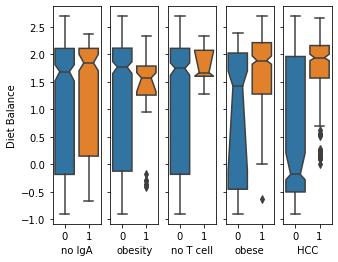

In [71]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=microbe_md, y='balance', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='obese', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='HCC', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel('Diet Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

Text(0.5, 0, 'Obese')

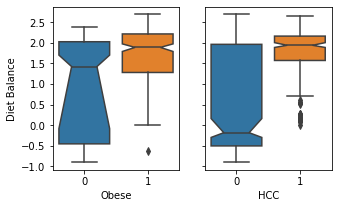

In [72]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))

sns.boxplot(data=microbe_md, y='balance', x='obese', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=microbe_md, y='balance', x='HCC', notch=True, ax=ax[1], bootstrap=1000)

ax[0].set_ylabel('Diet Balance')
ax[1].set_ylabel('')
ax[0].set_xlabel('Obese')

Comparison against DESeq2 (both loadings and balances)

In [73]:
!ls ../application/HCC

deseq_metabolites.csv                microbe_metabolites_analysis_otu.txt
deseq_microbiome.csv                 microbiome_analysis.xlsx
metabolites_analysis.txt             microbiome_analysis_otu.txt
metabolites_analysis.xlsx            microbiome_metabolites_data.xlsx
microb_metabolites_analysis.xlsx     plots


In [74]:
deseq2

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Phenotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
276629,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__S24-7,g__,s__,no_IgA,6.704298,-1.483728,0.307327,-4.827854,1.380125e-06,9.494045e-06
4306262,k__Bacteria,p__Verrucomicrobia,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Verrucomicrobiaceae,g__Akkermansia,s__muciniphila,no_IgA,108.401026,-2.539784,0.412973,-6.150002,7.748213e-10,9.151663e-09
181348,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Coprococcus,s__,no_IgA,10.411601,-0.022041,0.215269,-0.102388,9.184486e-01,9.487604e-01
184451,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__,no_IgA,774.575546,0.686406,0.278115,2.468067,1.358449e-02,3.221171e-02
3957916,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__,no_IgA,24.654705,-0.493799,0.236665,-2.086491,3.693416e-02,7.442271e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442831310,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__,adenomas,289.958616,-1.892928,0.570824,-3.316135,9.127158e-04,4.597383e-03
23157009,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruminococcus,s__,adenomas,5.445042,-0.742298,0.458251,-1.619852,1.052642e-01,2.185638e-01
8386859,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Oscillospira,s__,adenomas,3.342517,-3.809689,1.876314,-2.030412,4.231471e-02,1.070661e-01
3017279,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__,s__,adenomas,2.388484,-1.251844,1.339658,-0.934451,3.500714e-01,4.809061e-01


In [90]:
deseq2 = pd.read_csv('../application/HCC/deseq_microbiome.csv')
deseq2['OTU_id'] = deseq2['OTU_id'].astype(np.str)
deseq2_obese = deseq2.query("Phenotype == 'obese'").set_index('OTU_id')
deseq2_HCC = deseq2.query("Phenotype == 'HCC'").set_index('OTU_id')

/var/folders/w2/6wc3tcs56jl0x12ct8r03pf5h8vjhg/T/ipykernel_19968/4285598577.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  deseq2['OTU_id'] = deseq2['OTU_id'].astype(np.str)


In [93]:
len(set(deseq2_HCC.index) & set(microbe_ranks.index))

709

654
709


/var/folders/w2/6wc3tcs56jl0x12ct8r03pf5h8vjhg/T/ipykernel_19968/4040191484.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax[0].scatter(deseq2_obese.loc[common_taxa, 'log2FoldChange'],
/var/folders/w2/6wc3tcs56jl0x12ct8r03pf5h8vjhg/T/ipykernel_19968/4040191484.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  microbe_ranks.loc[common_taxa])
/var/folders/w2/6wc3tcs56jl0x12ct8r03pf5h8vjhg/T/ipykernel_19968/4040191484.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax[1].scatter(deseq2_HCC.loc[common_taxa, 'log2FoldChange'],
/var/folders/w2/6wc3tcs56jl0x12ct8r03pf5h8vjhg/T/ipykernel_19968/4040191484.py:16: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  microbe_ranks.loc[common_taxa])


Text(0.5, 0, 'DESeq2 (HCC)')

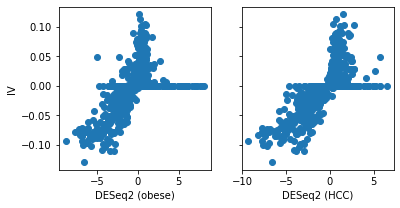

In [95]:
common_taxa = set(microbe_ranks.index) & set(deseq2_obese.index)
print(len(common_taxa))
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax[0].scatter(deseq2_obese.loc[common_taxa, 'log2FoldChange'], 
              microbe_ranks.loc[common_taxa])
ax[0].set_xlabel('DESeq2 (obese)')
ax[0].set_ylabel('IV')
#ax[0].set_xlim([-7, 7])
#ax[0].set_ylim([-0.4, 0.4])
#ax[0].plot([-5, 5], [-0.3, 0.3], 'r')

common_taxa = set(microbe_ranks.index) & set(deseq2_HCC.index)
print(len(common_taxa))

ax[1].scatter(deseq2_HCC.loc[common_taxa, 'log2FoldChange'], 
              microbe_ranks.loc[common_taxa])
ax[1].set_xlabel('DESeq2 (HCC)')
#ax[1].set_ylabel('GOFar')
#ax[1].set_xlim([-7, 7])
#ax[1].set_ylim([-0.4, 0.4])
#ax[1].plot([-5, 5], [-0.3, 0.3], 'r')

In [101]:
idx = deseq2_HCC.query('log2FoldChange > 0').index
neg_count = np.mean(microbe_ranks.loc[idx] < 0)
zero_count = np.mean(microbe_ranks.loc[idx] == 0)
pos_count = np.mean(microbe_ranks.loc[idx] > 0)
print(neg_count, zero_count, pos_count)

0.011834319526627219 0.5118343195266272 0.47633136094674555


In [108]:
deseq2_HCC.loc[(microbe_ranks.loc[idx] == 0).index].query('padj < 0.01').head(50)

,Unnamed: 0,Kingdom,Phylum,Class,Order,Family,Genus,Species,Phenotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
OTU_id,,,,,,,,,,,,,,,
181348,1938,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Coprococcus,s__,HCC,10.411601,0.814419,0.181881,4.477761,7.542989e-06,2.728561e-05
184451,1939,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__,HCC,774.575546,0.742136,0.242127,3.065062,2.176252e-03,5.302276e-03
3957916,1941,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__,HCC,24.654705,1.203757,0.198465,6.065332,1.316811e-09,7.652614e-09
4454531,1945,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacteriales,f__Enterobacteriaceae,g__,s__,HCC,5.243478,4.974761,1.005642,4.946853,7.542306e-07,2.970831e-06
258522,1947,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__,s__,HCC,216.533639,1.451820,0.252170,5.757304,8.546770e-09,4.455632e-08
178959,1957,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Oscillospira,s__,HCC,38.850308,1.015300,0.224452,4.523468,6.083438e-06,2.223277e-05
236142,1959,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacteriales,f__Enterobacteriaceae,g__,s__,HCC,5.835552,4.985448,1.583458,3.148456,1.641355e-03,4.126668e-03
1028632,1961,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacteriales,f__Enterobacteriaceae,g__,s__,HCC,3.617937,5.163428,1.029396,5.015980,5.276372e-07,2.137684e-06
182061,1962,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__,s__,HCC,2.272152,0.673167,0.235010,2.864417,4.177779e-03,9.314608e-03


In [111]:
(deseq2_HCC
 .loc[microbe_ranks.loc[(microbe_ranks > 0)].index]
 .query('log2FoldChange < 0'))

,Unnamed: 0,Kingdom,Phylum,Class,Order,Family,Genus,Species,Phenotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
98048,2147,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Oscillospira,s__,HCC,10.453519,-0.254806,0.385766,-0.660520,0.508920,0.630812
2937207,2623,k__Bacteria,p__Deferribacteres,c__Deferribacteres,o__Deferribacterales,f__Deferribacteraceae,g__Mucispirillum,s__schaedleri,HCC,496.521325,-0.274969,0.231379,-1.188389,0.234680,0.330533
181719,2000,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__,HCC,339.831488,-0.138655,0.206477,-0.671530,0.501883,0.623179


# Metabolomics

In [ ]:
import biom
metabolites = biom.load_table('../data/hcc-data/metabolites.biom').to_dataframe().T
metabolite_md = pd.read_table('../data/hcc-data/metabolite_feature_metadata.txt', index_col=0)
metaboliteV = pd.read_excel('../results/metabolites_analysis.xlsx', sheet_name='Figure V', index_col=0)
metabolite_md = metabolite_md.reset_index().dropna(subset=['Compound_Name'])
metabolite_md.index = metaboliteV.index

metabolites = metabolites[metabolite_md['sampleid'].values]
metabolites.columns = metabolite_md.index

metadata = pd.read_table('../data/hcc-data/cleaned_qiime_metadata.txt', index_col=0)

host_md = pd.read_table('../data/sample_information_from_prep_2458.tsv', index_col=0)
metadata = pd.merge(metadata, host_md[['host_subject_id']].reset_index(), 
                    left_index=True, right_on='host_subject_id')
metadata = pd.merge(metadata, microbe_md, left_on='sample_id', right_index=True)
metadata = metadata.set_index('host_subject_id')

In [ ]:
fig, ax = plt.subplots(figsize=(2, 8))
metabolite_ranks = metaboliteV['V2'].sort_values()
pd.DataFrame(metabolite_ranks.loc[np.abs(metabolite_ranks) > 0.065]).plot.barh(ax=ax)
ax.set_title('V2 : Immune Instrumental Variable')

In [ ]:
denom = metabolite_ranks.loc[metabolite_ranks < 0].index
num = metabolite_ranks.loc[metabolite_ranks > 0].index
v = pd.DataFrame({'balance' : np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)})
metadata = pd.merge(metadata, v, left_index=True, right_index=True)

In [ ]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metadata, y='balance', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='obese_x', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metadata, y='balance', x='HCC_x', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel('V2 : Dietary Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

In [ ]:
deseq2 = pd.read_csv('../results/deseq_metabolites.csv', index_col=0)
# deseq2 = pd.merge(deseq2, metabolite_md, 
deseq2_obese = deseq2.loc[deseq2['Phenotype'] == 'obese']
#deseq2_obese = deseq2_obese.set_index('Variable')

deseq2_HCC = deseq2.loc[deseq2['Phenotype'] == 'HCC']
#deseq2_HCC = deseq2_HCC.set_index('Variable')

# Merged microbe-metabolite datasets

In [ ]:
mmV = pd.read_excel('../results/microb_metabolites_analysis (1).xlsx', 
                    sheet_name='Figure V', index_col=0)

microbe_fmd = pd.read_excel('../results/microb_metabolites_analysis (1).xlsx', 
                    sheet_name='microbiome_meta', index_col=0)
metabolite_fmd = pd.read_excel('../results/microb_metabolites_analysis (1).xlsx', 
                               sheet_name='Metabolites_meta', index_col=0)

microbe_fmd['OTUID'] = list(map(lambda x: int(str(x)[1:]), microbe_fmd.index))

In [ ]:
bname = 'V3'
metabolite_ranks = metaboliteV2[bname].sort_values()
denom = metabolite_ranks.loc[metabolite_ranks < 0].index
num = metabolite_ranks.loc[metabolite_ranks > 0].index
v = pd.DataFrame({
    f'metabolite{bname}' : np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)
})
metabolite_samp_md = pd.merge(metadata, v, left_index=True, right_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(2, 8))
pd.DataFrame(metabolite_ranks.loc[np.abs(metabolite_ranks) > 0.03]).plot.barh(ax=ax)
ax.set_title('V2 : Immune Instrumental Variable')

In [ ]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='obese_x', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metabolite_samp_md, y=f'metabolite{bname}', x='HCC_x', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel(f'Metabolite {bname} : Immune Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

In [ ]:
bname = 'V3'
microbe_ranks = microbeV2[bname].sort_values()
denom = microbe_ranks.loc[microbe_ranks < 0].index
num = microbe_ranks.loc[microbe_ranks > 0].index
v = pd.DataFrame({
    f'microbe{bname}' : np.log(family[num] + 1).mean(axis=1) - np.log(family[denom] + 1).mean(axis=1)
})
microbe_samp_md = pd.merge(microbe_md, v, left_index=True, right_index=True)

# Cross-reference against MMvec

In [ ]:
metabolite_fmd

In [ ]:
mmvec_metab = res.samples.loc[]